## Data Dictionary
Variable | Definition | Key
---------|------------|--------
survival | Survival | 0 = No, 1 = Yes
pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd
sex | Sex	
Age | Age in years	
sibsp | # of siblings / spouses aboard the Titanic	
parch | # of parents / children aboard the Titanic	
ticket | Ticket number	
fare | Passenger fare	
cabin | Cabin number	
embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton


## Variable Notes
`pclass`: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

`age`: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

`sibsp`: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

`parch`: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

## Setup

In [1]:
%run "./0_titanic_utils.ipynb"

In [25]:
df = read_clean_titanic('./data/train.csv', use_dummies=False)

In [26]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,is_female,is_age_infant,is_age_child,...,is_age_old_adult,is_age_elderly,is_age_master,is_age_mister,is_age_miss,is_age_misses,is_family,is_parent,is_child,age_cat
0,1,0,3,male,22.0,7.2500,S,0,0,0,...,0,0,0,1,0,0,1,0,0,mister
1,2,1,1,female,38.0,71.2833,C,1,0,0,...,0,0,0,0,0,1,1,0,0,misses
2,3,1,3,female,26.0,7.9250,S,1,0,0,...,0,0,0,0,1,0,0,0,0,miss
3,4,1,1,female,35.0,53.1000,S,1,0,0,...,0,0,0,0,0,1,1,0,0,misses
4,5,0,3,male,35.0,8.0500,S,0,0,0,...,0,0,0,1,0,0,0,0,0,mister


# Investigations

In [27]:
df['Fare'].value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
35.0000     1
28.5000     1
6.2375      1
14.0000     1
10.5167     1
Name: Fare, Length: 247, dtype: int64

In [28]:
# ## Prove that our Age Groups all have Ages

# def get_age_groups(df, field):
#     all_df = df[df[field] == 1]
#     no_age_df = all_df[all_df["Age"].isna()]
#     age_df = all_df[all_df["Age"].isna() == False]
#     return all_df, age_df, no_age_df

# def print_lengths(pref, all_df, age_df, no_age_df):
#     print(f"{pref:>6} a:{len(all_df):>6} w:{len(age_df):>6} no:{len(no_age_df):>6}")
    
# (masters_df, masters_age_df, masters_no_age_df) = get_age_groups(df, "is_age_master")
# (misters_df, misters_age_df, misters_no_age_df) = get_age_groups(df, "is_age_mister")
# (miss_df, miss_age_df, miss_no_age_df) = get_age_groups(df, "is_age_miss")
# (misses_df, misses_age_df, misses_no_age_df) = get_age_groups(df, "is_age_misses")

# print_lengths("master", masters_df, masters_age_df, masters_no_age_df)
# print_lengths("mr", misters_df, misters_age_df, misters_no_age_df)
# print_lengths("miss", miss_df, miss_age_df, miss_no_age_df)
# print_lengths("mrs", misses_df, misses_age_df, misses_no_age_df)
                  
# print(f"{len(masters_df) + len(misters_df) + len(miss_df) + len(misses_df) }  total by breakdown")
# print(f"{len(df) }  total raw")

# Investigations

In [29]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,is_female,is_age_infant,is_age_child,...,is_age_old_adult,is_age_elderly,is_age_master,is_age_mister,is_age_miss,is_age_misses,is_family,is_parent,is_child,age_cat
0,1,0,3,male,22.0,7.2500,S,0,0,0,...,0,0,0,1,0,0,1,0,0,mister
1,2,1,1,female,38.0,71.2833,C,1,0,0,...,0,0,0,0,0,1,1,0,0,misses
2,3,1,3,female,26.0,7.9250,S,1,0,0,...,0,0,0,0,1,0,0,0,0,miss
3,4,1,1,female,35.0,53.1000,S,1,0,0,...,0,0,0,0,0,1,1,0,0,misses
4,5,0,3,male,35.0,8.0500,S,0,0,0,...,0,0,0,1,0,0,0,0,0,mister


In [30]:
df.count()

PassengerId           889
Survived              889
Pclass                889
Sex                   889
Age                   889
Fare                  889
Embarked              889
is_female             889
is_age_infant         889
is_age_child          889
is_age_teen           889
is_age_young_adult    889
is_age_adult          889
is_age_old_adult      889
is_age_elderly        889
is_age_master         889
is_age_mister         889
is_age_miss           889
is_age_misses         889
is_family             889
is_parent             889
is_child              889
age_cat               889
dtype: int64

# Investigations

In [31]:
df.groupby("is_female")["Survived"].value_counts(normalize=True)

is_female  Survived
0          0           0.811092
           1           0.188908
1          1           0.740385
           0           0.259615
Name: Survived, dtype: float64

In [32]:
new_df = df.groupby("is_female")["Survived"].value_counts(normalize=True)
new_df = new_df.mul(100).rename('Percent').reset_index()
new_df

,is_female,Survived,Percent
0,0,0,81.109185
1,0,1,18.890815
2,1,1,74.038462
3,1,0,25.961538


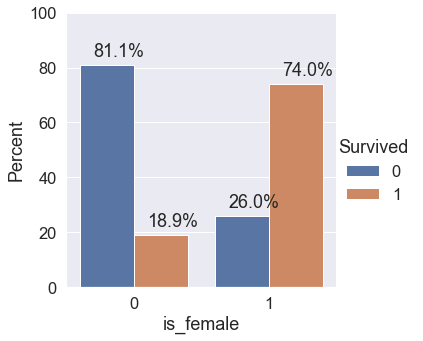

In [33]:
g = sns.catplot(x="is_female", y='Percent', hue="Survived", kind='bar', data=new_df)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x() + (p.get_width() /4)
    txt_y = p.get_height() + 3
    g.ax.text(txt_x,txt_y,txt)

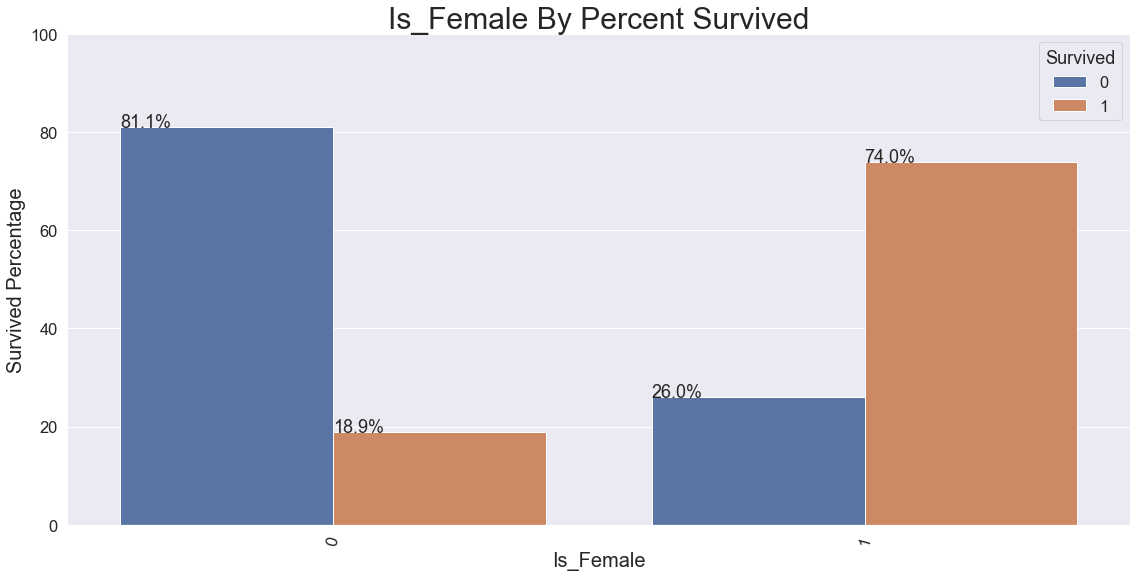

In [34]:
plotting_percentages(df, "is_female", "Survived")

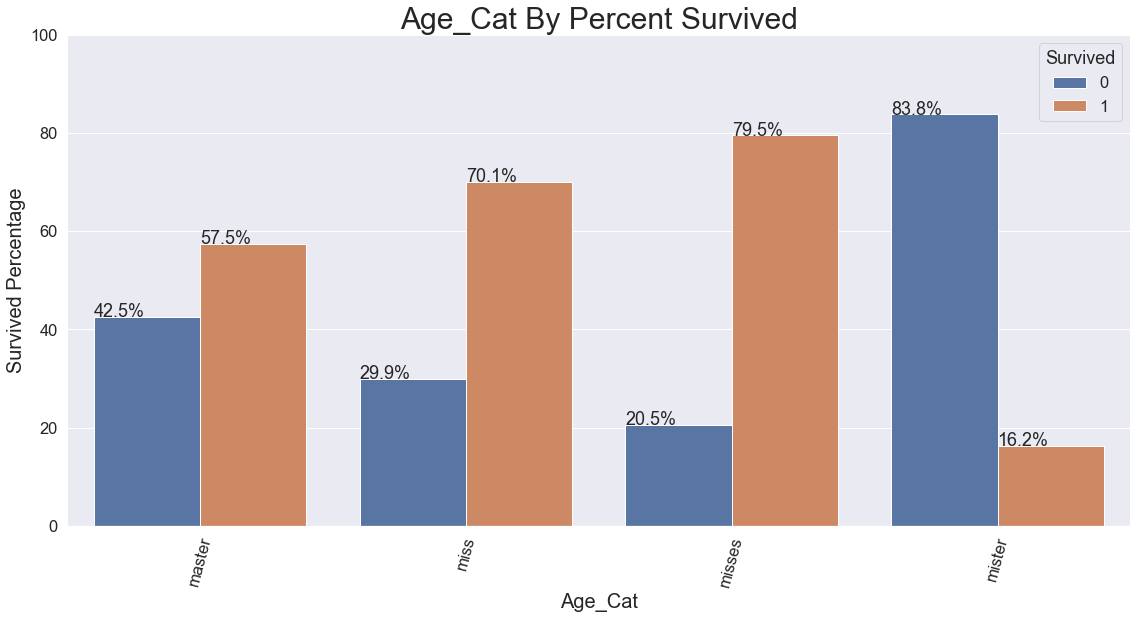

In [35]:
plotting_percentages(df, "age_cat", "Survived")

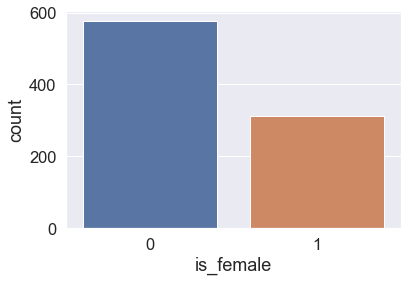

In [36]:
ax = sns.countplot(x="is_female", data=df)
# surv_df["Sex"].value_counts().plot(kind="bar")

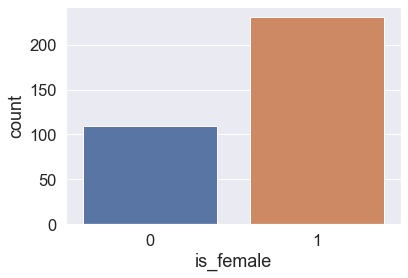

In [37]:
surv_df = df[df["Survived"] == 1]
ax = sns.countplot(x="is_female", data=surv_df)

In [38]:
def count_plot(df, field, title_prefix="Survived"):
    plt.figure(figsize=(20,5),dpi=100)
    sns.countplot(x=field, 
                  data=surv_df, 
                        order=surv_df[field].value_counts().index).set_title(f"{title_prefix} : {field}")

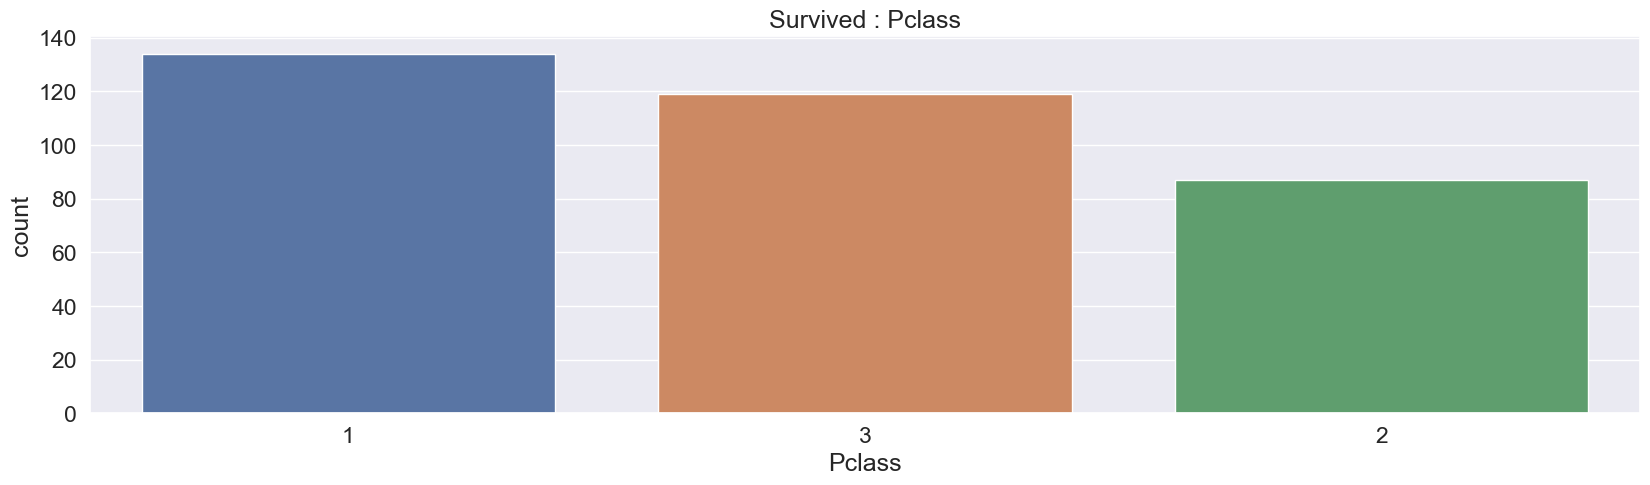

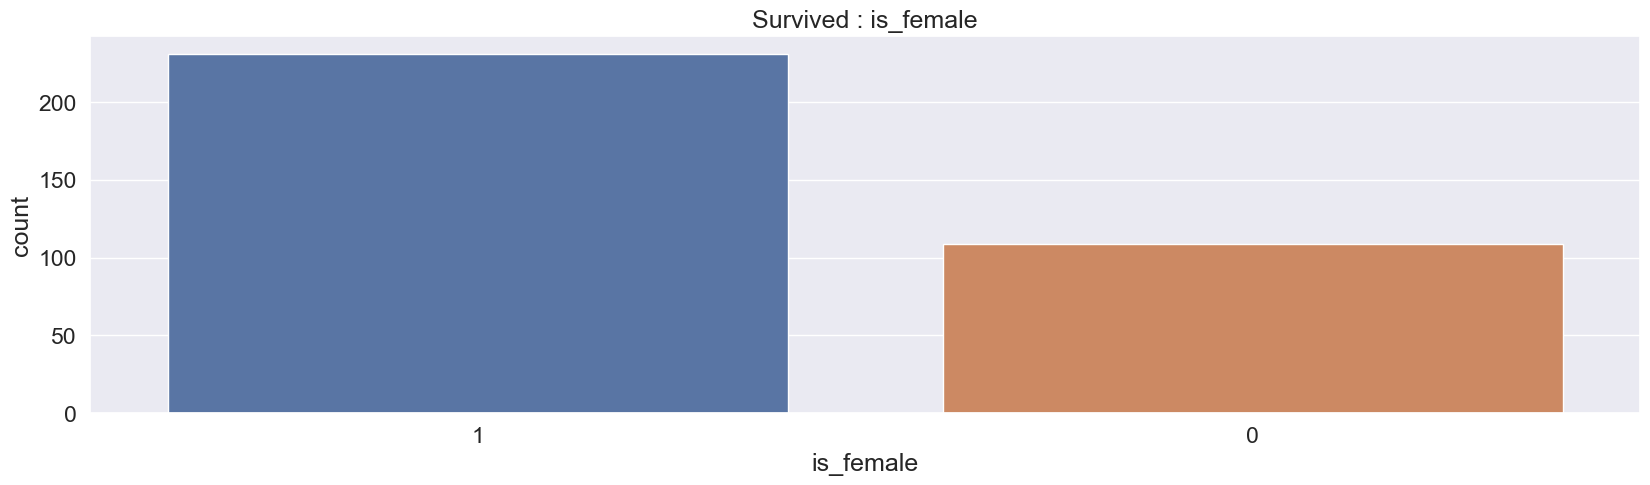

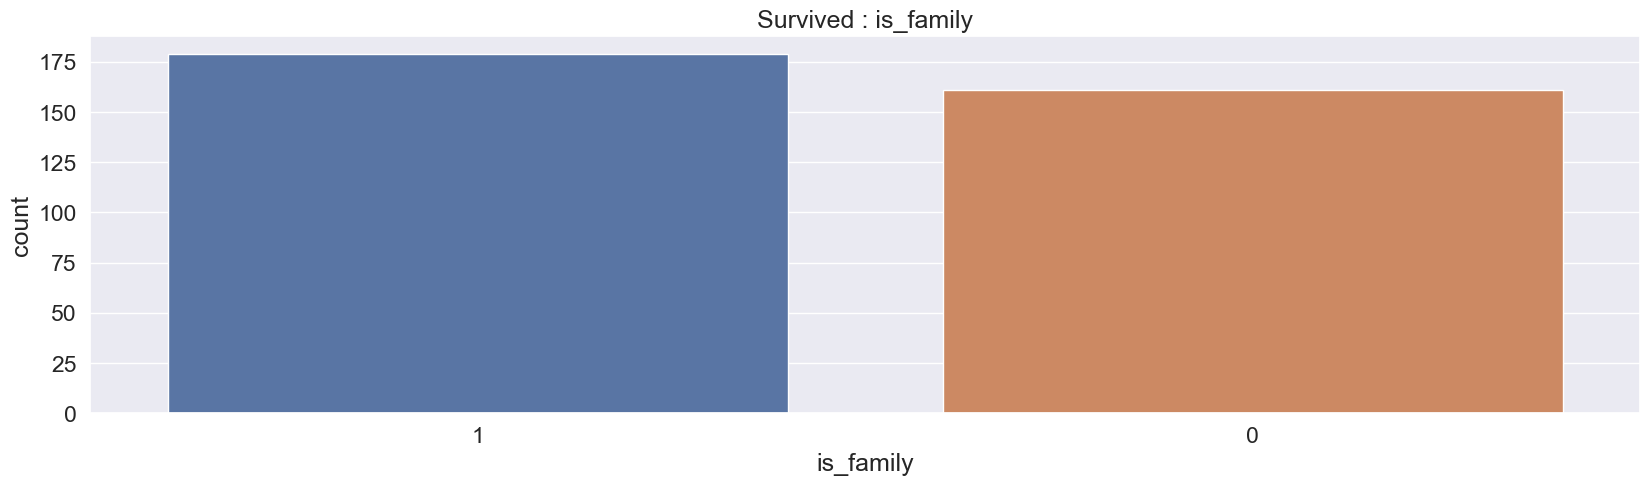

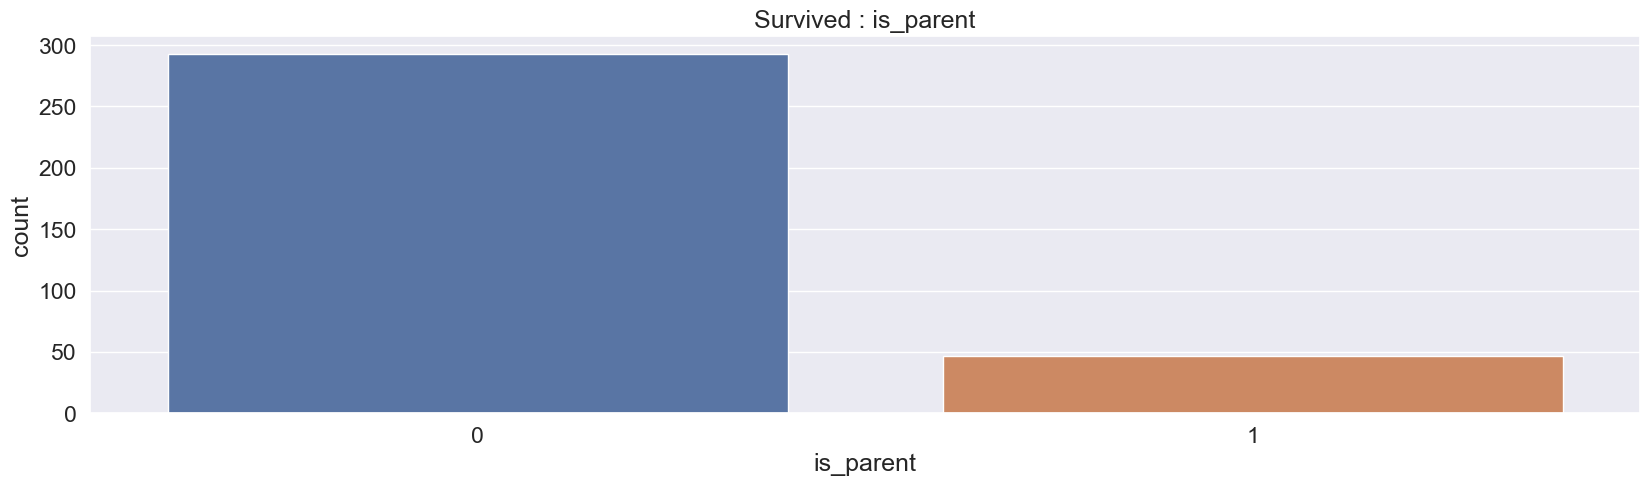

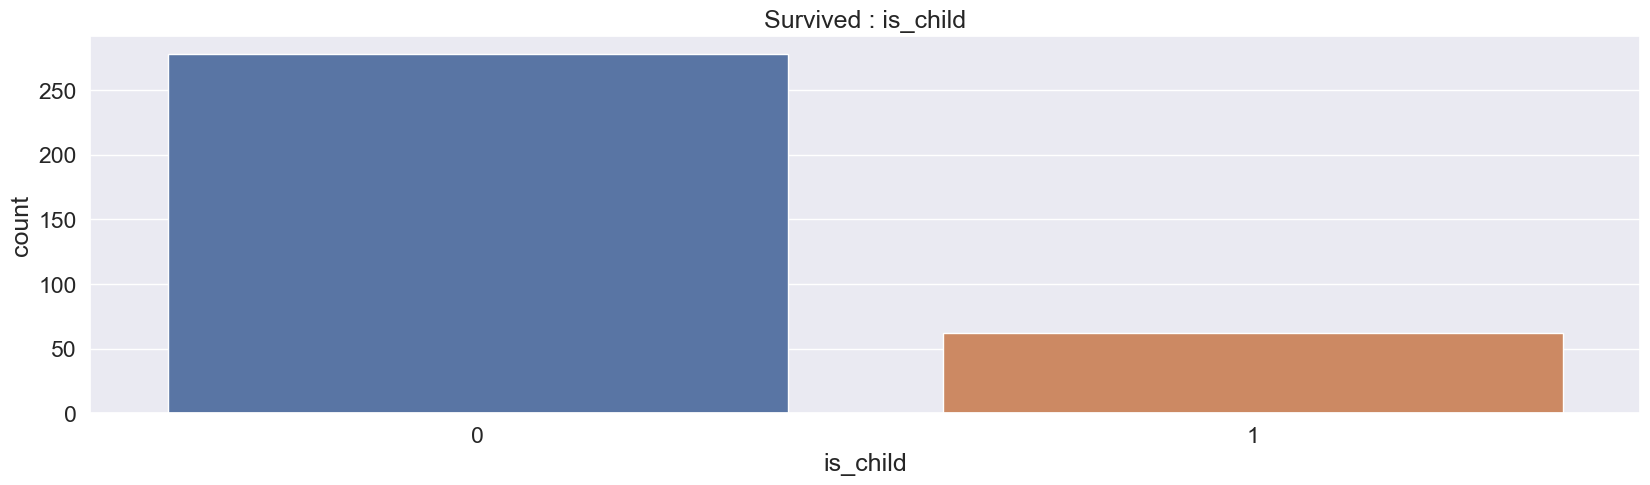

In [39]:
fields = ["Pclass","is_female","is_family", "is_parent", "is_child"]
for field in fields:
    count_plot(surv_df, field)

## Fare and Age

These need to be bucketed to bring any meaning. First to find out what the values look like.

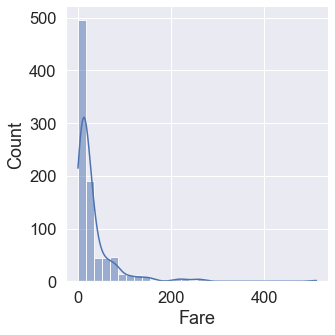

In [40]:
sns.displot(df, x="Fare", bins=30, kde=True);

<AxesSubplot:>

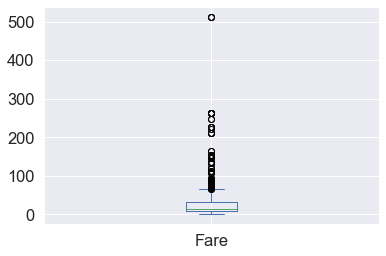

In [41]:
df["Fare"].plot(kind="box")

In [42]:
df[['Fare', "Survived"]].sort_values("Fare")

,Fare,Survived
271,0.0000,1
597,0.0000,0
302,0.0000,0
633,0.0000,0
277,0.0000,0
...,...,...
341,263.0000,1
88,263.0000,1
737,512.3292,1
679,512.3292,1


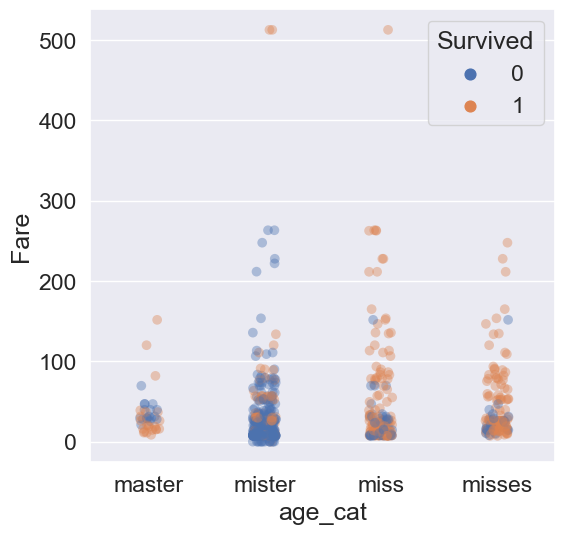

In [43]:
plt.figure(figsize=(6,6),dpi=100)
ax = sns.stripplot(x="age_cat", y="Fare", data=df, hue="Survived", 
                   s=7, alpha=0.4, 
                   order=["master", "mister", "miss", "misses"]);

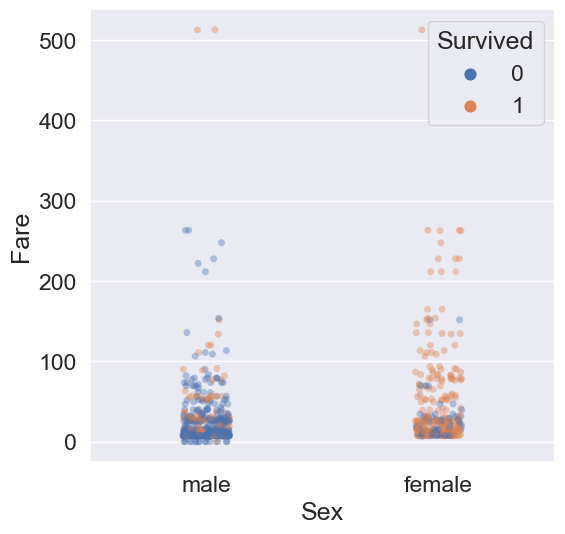

In [44]:
plt.figure(figsize=(6,6),dpi=100)
ax = sns.stripplot(data=df, x="Sex", y="Fare", hue="Survived", alpha=0.4);

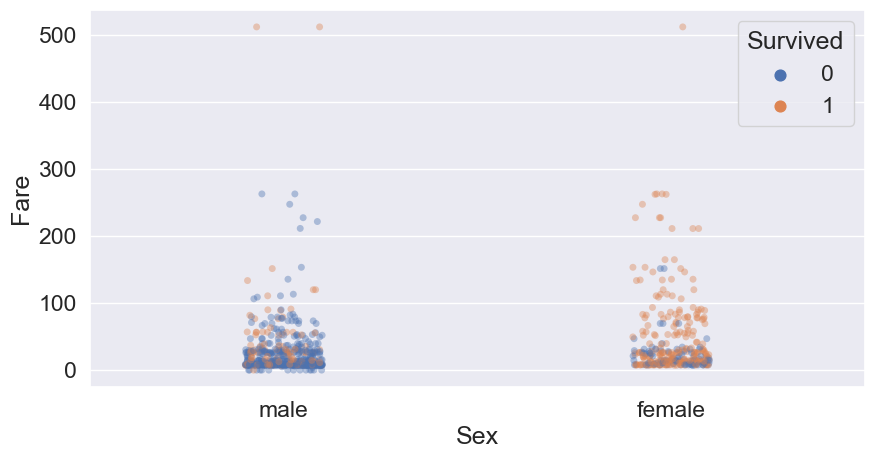

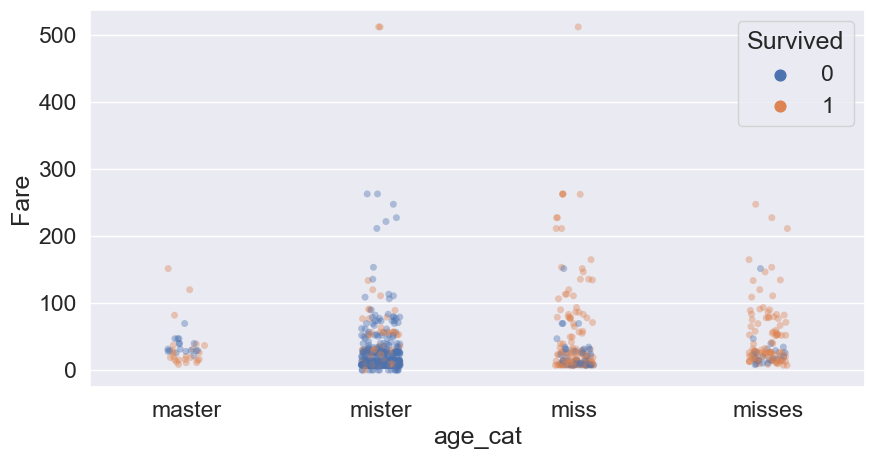

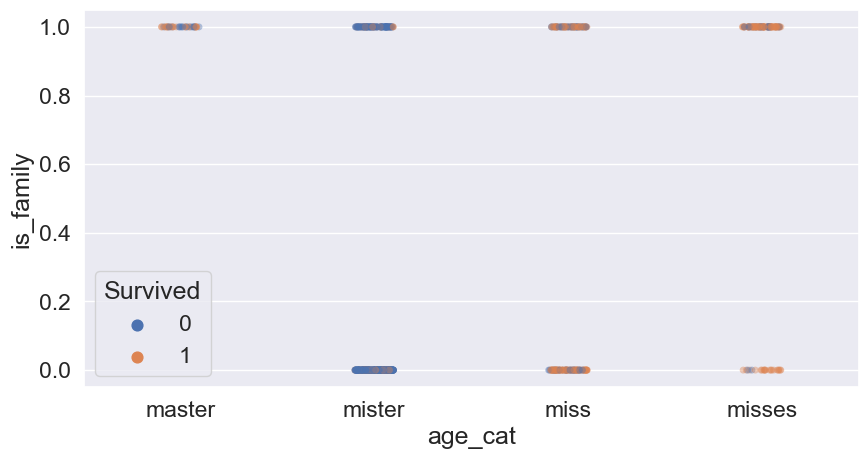

In [45]:
def strip_by_fields(df, x, y, order=None):
    plt.figure(figsize=(10,5),dpi=100)
    sns.stripplot(data=df.sort_values(field), x=x, y=y, hue="Survived",
                    alpha=0.4, order=order);
    plt.show();



strip_by_fields(df, "Sex", "Fare")
strip_by_fields(df, "age_cat", "Fare", order=["master", "mister", "miss", "misses"])
strip_by_fields(df, "age_cat", "is_family", order=["master", "mister", "miss", "misses"])
# strip_by_field(df, "Age")
# strip_by_field(df, "is_female")

<AxesSubplot:>

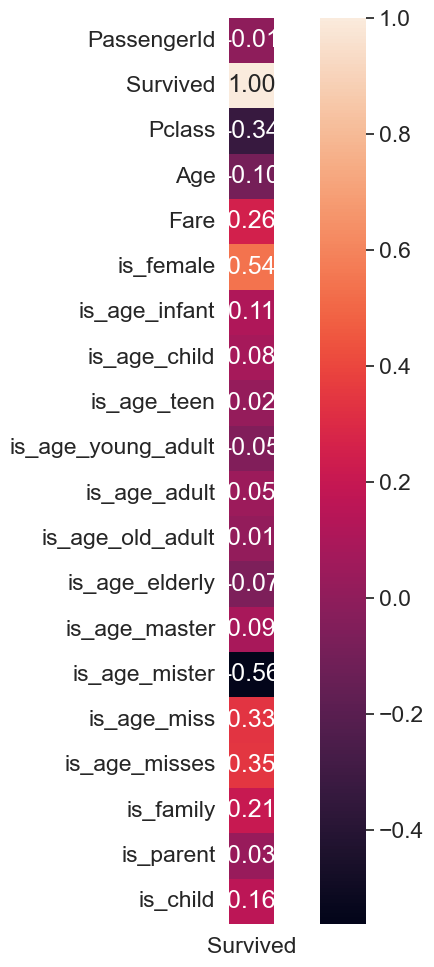

In [46]:
plt.figure(figsize=(12,12),dpi=100)
sns.heatmap(data=df.corr()[["Survived"]], square=True, annot=True, 
            fmt=".2f"
            # center=0,
            # cmap="viridis"
            # cmap="cubehelix"
            # cmap="YlOrBr"
            # cmap="vlag"
            # cmap="coolwarm_r"
            )

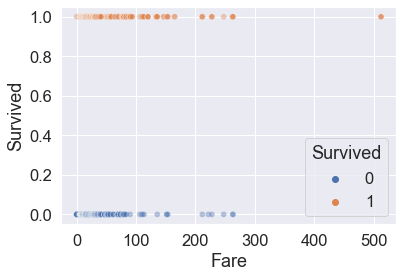

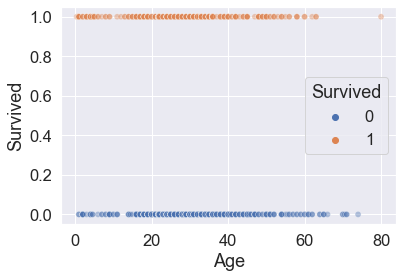

In [47]:
def scat_by_field(df, field):
    sns.scatterplot(data=df.sort_values(field), x=field, y="Survived", hue="Survived",
                    alpha=0.4);
    plt.show();
scat_by_field(df, "Fare")
scat_by_field(df, "Age")